# Capstone Project - Car Crash Severity Analysis (Week 3)
### Applied Data Science Capstone by IBM/Coursera

## Other links (i.e Report & Presentation)
* https://1drv.ms/w/s!AqVQsWO6gA3LjCl0QdkFYvurx3Hb?e=uSKmBj
* https://1drv.ms/p/s!AqVQsWO6gA3LjCterx90b6KUu_G1?e=azJHvo

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

A major problem for **emergency responders** is to assess the severity of the distress. If more ambulance staff is dispatched, emergency responders might not have enough resources to effectively respond to a second distress call and if too few staff are dispatched, the number of casualities or injuries might increase. It is the same for police offciers and fire fighters. Deployment of too many or too few policemen and fire fighters is problematic hence it is of profound significance that emergency responders have an accurate estimate of the severity of traffic accidents they are rushing to attend to. What makes this an even more important challenge is the rising frequency of such incidents. The quantity of fatal crashes went from 508 in 2016 to 525 in 2017, resulting in the death of 555 people so the resources at disposal are getting even more stressed. 

This study aims to identify patterns and uncover insights that will help the responders deploy more efficiently and accurately. Some statistics have long been in the circulation e.g the highest number of crashes occur on Saturdays or in the month of November. This study attempts to uncover more insights and train a ML algorithm to accurately predict severity of a car crash.


## Data <a name="data"></a>

The data for this study has been sourced from Seattle Traffic Department. It is high quality data because it has recorded many accidents under varying condions e.g the accidents on a specific block under snowy, rainy and sunny weather conditions. This degree of detail help identify relationships between important factors that collaborate to affect an accident's severity. 

Some fields from the data are briefly described below:
- SEVERITYCODE: is the severity of the accident known? How severve was it? Did passengers incur only minor injuries or did it prove to be fatal?
- COLLISIONTYPE: the motion of the vehicles involved
- PERSONCOUNT: total number of people involved in the collision
- PEDCOUNT: The number of pedestrians involved in the collision
- INJURIES: The number of total injuries in the collision
- SERIOUSINJURIES: The number of serious injuries in the collision
- FATALITIES: The number of fatalities in the collision
- JUNCTIONTYPE: Category of junction at which collision took place
- WEATHER: The description of the weather conditions during the time of the collision
- ROADCOND: The condition of the road during the collision
- SPEEDING: Whether or not speeding was a factor in the collision
- INCDATE: The date of the incident
- INCDTTM: The date and time of the incident.

Futher features can be developed from the data set which may or may not be factors e.g INCDATE (date of incident) field can be used to create a new feature 'Day of Week' and the data might predict accidents tend to be more severe during certain days. 


### External resources

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import jaccard_score, f1_score, log_loss, accuracy_score
%matplotlib inline

### Get Raw Data

In [4]:
# Importing Data; Seattle accident data
df = pd.read_csv('Data-Collisions.csv')
df.head()

C:\Users\Rohaan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Methodology <a name="methodology"></a>

In this project the efforts have been directed on detecting high confidence relationships that can be used for predictions and training an AI that can utilize that data to make accurate predictions.

The first stage in this study is to define a few functions that will ease the analysis and streamline coding. 

The second step is the **data wrangling**. All data fields have been accessed for their relevancy and removed if it has been estimated that they do not contain any critical information from a predicting perspective. Data formats have also  been worked out at this stage. Rows with unknown values have been removed as it is very difficult to come up with accurate averages/median values that will not contribute to divergence of the edited row from the rest of the data. It was futher established that times and dates of the data do not contain any significant skew. 

The third step in our analysis is the exploration of various relationships that might have a strong relation to the severity of car accidents. **Pearson Correlation** and **Spearman Correlations** were used for numerical data and pandas' built in **Describe function** was used for the object type data. 

In final step the study focused on the relevant fields areas and employed those to train various **Classification MLs** algorithms to develop the most accurate agent capable of predictions. Owing to intensive computational requirements of Regression ML and given their speciality in calculating probabilities, which is not the purpose here, Regression algorithms were not employed and only 'linear' algorithm of Support Vector Machine was tested. 

### Function Definitions

In [5]:
# determines if dataframe has rows with missing values
def is_data_missing(df_to_check):
    missing_data = df_to_check.isnull()
    for column in missing_data.columns.tolist():
        if(missing_data[column].isnull):
            print(column)
            print(missing_data[column].value_counts())
            
# Balancing Labels
def balance_labels(data_frame,series_name):
    """ takes the data frame and series containing labels, diagnoses unbalancing and randomly choses fields to restore balance_co Series must have 2 labels"""
    
    # count labels
    cnt_code_A, cnt_code_B = data_frame[series_name].value_counts()
    
    # determine skew
    if(cnt_code_A != cnt_code_B):
        
        # determine number of additional records
        delta = abs(cnt_code_A-cnt_code_B)
        
        # sort data
        data_frame.sort_values(by = [series_name],inplace = True)
        
        # store codes
        code_A = data_frame[series_name].iloc[0]
        code_B = data_frame[series_name].iloc[-1]
        
        # randomly delete records to remove skew
        if (cnt_code_A>cnt_code_B):
            print('Data skewed towards label', code_A, 'by', delta, 'counts')
            to_remove = np.random.choice(data_frame[data_frame[series_name] == code_A].index, delta ,replace=False)
            data_frame.drop(to_remove, inplace = True)
            print('Balance restored.')
            
        else:
            print('Data skewed towards label', code_B, 'by', delta, 'counts')
            to_remove = np.random.choice(data_frame[data_frame[series_name] == code_B].index, delta ,replace=False)
            data_frame.drop(to_remove, inplace = True)
            print('Balance restored.')
    else:
        print('No skew detected :)')
        # fix skew via random selection
        
def evaluate_ai (y_testset, y_hat):
    print("AI's Accuracy: ", round(metrics.accuracy_score(y_testset, y_hat),2))
    print("AI's Jaccard Similarity Index: ", round(jaccard_score(y_testset, y_hat),2))
    print("AI's F1 Score : ", round(f1_score(y_testset, y_hat),2))
    print("AI's Log Loss: ", round(log_loss(y_testset, y_hat),2))

### Data Wrangling

In [6]:
# the parameters emergency responders will have access to
clean_df = df[['SEVERITYCODE', # Target
               'X',            # Some areas might have a higher 
               'Y',            # probability of more severe accidents
               'INCDATE',      # distribution/week
               'INCDTTM',       # distribution/time
               'WEATHER',      # bad weather, more accidents?
               'ROADCOND',     # bad condition, more severity?
               'LIGHTCOND',    # bad light, more severity?
               'HITPARKEDCAR',  # any pattern?
               'SEGLANEKEY'
              ]]

clean_df.dtypes

SEVERITYCODE      int64
X               float64
Y               float64
INCDATE          object
INCDTTM          object
WEATHER          object
ROADCOND         object
LIGHTCOND        object
HITPARKEDCAR     object
SEGLANEKEY        int64
dtype: object

In [9]:
# descriptive analysis
clean_df.describe(include = 'object')

,INCDATE,INCDTTM,WEATHER,ROADCOND,LIGHTCOND,HITPARKEDCAR
count,194673,194673,189592,189661,189503,194673
unique,5985,162058,11,9,9,2
top,2006/11/02 00:00:00+00,11/2/2006,Clear,Dry,Daylight,N
freq,96,96,111135,124510,116137,187457


In [10]:
# identifying missing data
is_data_missing(clean_df) # self-wrote function

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64
X
False    189339
True       5334
Name: X, dtype: int64
Y
False    189339
True       5334
Name: Y, dtype: int64
INCDATE
False    194673
Name: INCDATE, dtype: int64
INCDTTM
False    194673
Name: INCDTTM, dtype: int64
WEATHER
False    189592
True       5081
Name: WEATHER, dtype: int64
ROADCOND
False    189661
True       5012
Name: ROADCOND, dtype: int64
LIGHTCOND
False    189503
True       5170
Name: LIGHTCOND, dtype: int64
HITPARKEDCAR
False    194673
Name: HITPARKEDCAR, dtype: int64
SEGLANEKEY
False    194673
Name: SEGLANEKEY, dtype: int64


- critical parameters are missing so better to just remove all of the missing rows

In [11]:
# replace Unknowns with NAN
clean_df.replace({'Unknown' : np.nan})

# drop all rows with incomplete information
clean_df.dropna(inplace = True)

# descriptive analysis
clean_df.describe(include='object')

C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,INCDATE,INCDTTM,WEATHER,ROADCOND,LIGHTCOND,HITPARKEDCAR
count,184167,184167,184167,184167,184167,184167
unique,5947,155840,11,9,9,2
top,2006/11/02 00:00:00+00,11/2/2006,Clear,Dry,Daylight,N
freq,88,88,108833,121871,113522,177537


- HITPARKEDCAR can be binary encoded

In [12]:
clean_df.HITPARKEDCAR.unique()

array(['N', 'Y'], dtype=object)

In [13]:
clean_df.HITPARKEDCAR.replace(to_replace = {'N' : 0, 'Y' : 1}, inplace = True)
clean_df.HITPARKEDCAR.unique()

C:\Users\Rohaan\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


array([0, 1], dtype=int64)

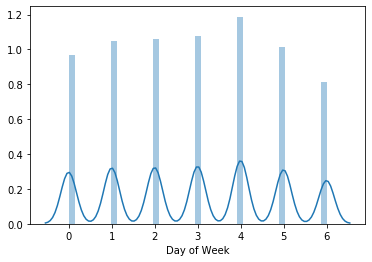

In [14]:
# making date and time useful

# removing time section
date_df = clean_df['INCDATE'].str.split(pat = " ", n = 1, expand = True)
date_df.drop(columns= [1], inplace = True)

# reformating date in a useful way
date_df.columns = ['Date']
date_df = date_df.Date.str.split(pat = "/", n = -1, expand = True)
date_df.columns = ['year','month','day']
date_df['Date'] = pd.to_datetime(date_df)
date_df.drop(columns = ['year','month','day'], inplace = True)

# engineering features
date_df['Day of Week'] = date_df['Date'].dt.dayofweek
date_df['Day of Year'] = date_df['Date'].dt.dayofyear
sns.distplot (a = date_df['Day of Week'])

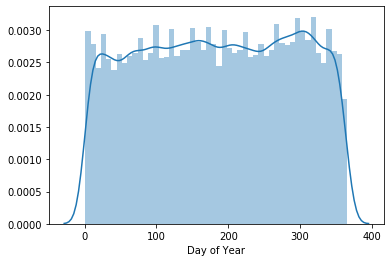

In [15]:
sns.distplot (a = date_df['Day of Year'])

In [16]:
clean_df['Day of Week'] = date_df['Date'].dt.dayofweek
clean_df['Day of Year'] = date_df['Date'].dt.dayofyear

C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


both have slight negative skews 

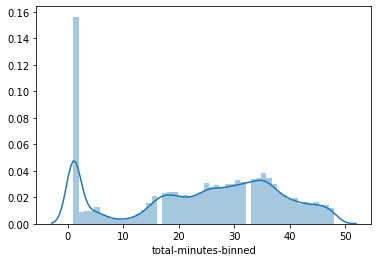

In [17]:
# convert time to 24H format
time_df = pd.DataFrame(pd.to_datetime(clean_df['INCDTTM']))
time_df.columns = ['Datetime']

# extract hour, minute information
time_df['Hour'] = time_df.Datetime.dt.hour
time_df['Minutes'] = time_df.Datetime.dt.minute

# engineer total hours feature
time_df['Total Minutes'] = time_df['Hour']*60+time_df['Minutes']
time_df['Total Minutes'].astype('int')

# make bins
bin_interval = 30 #minutes
bins = np.linspace(min(time_df['Total Minutes']), max(time_df['Total Minutes']), int((24*60/bin_interval)+1))
(x,) = bins.shape
group_names = [*range(1,x)]
time_df['total-minutes-binned'] = pd.cut(time_df['Total Minutes'], bins, labels=group_names, include_lowest=True )

# visualize distribution
sns.distplot(time_df['total-minutes-binned'])

In [18]:
# drop unformatted, redundant data
clean_df.drop(columns = ['INCDATE','INCDTTM'], inplace = True)

# insert potentially time and date fields
clean_df['Date'] = date_df['Date']
clean_df['Hour'] = time_df['Hour']
clean_df['Minutes'] = time_df['Minutes']

# snippet of data
clean_df.head(10)

C:\Users\Rohaan\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,SEVERITYCODE,X,Y,WEATHER,ROADCOND,LIGHTCOND,HITPARKEDCAR,SEGLANEKEY,Day of Week,Day of Year,Date,Hour,Minutes
0,2,-122.323148,47.703140,Overcast,Wet,Daylight,0,0,2,86,2013-03-27,14,54
1,1,-122.347294,47.647172,Raining,Wet,Dark - Street Lights On,0,0,2,354,2006-12-20,18,55
2,1,-122.334540,47.607871,Overcast,Dry,Daylight,0,0,3,323,2004-11-18,10,20
3,1,-122.334803,47.604803,Clear,Dry,Daylight,0,0,4,88,2013-03-29,9,26
4,2,-122.306426,47.545739,Raining,Wet,Daylight,0,0,2,28,2004-01-28,8,4
5,1,-122.387598,47.690575,Clear,Dry,Daylight,0,0,5,110,2019-04-20,17,42
6,1,-122.338485,47.618534,Raining,Wet,Daylight,0,0,1,344,2008-12-09,0,0
7,2,-122.320780,47.614076,Clear,Dry,Daylight,0,6855,2,106,2020-04-15,17,47
8,1,-122.335930,47.611904,Clear,Dry,Daylight,0,0,3,166,2006-06-15,13,0
9,2,-122.384700,47.528475,Clear,Dry,Daylight,0,0,0,79,2006-03-20,15,49


In [19]:
# balancing labels via random undersampling
balance_labels(clean_df,'SEVERITYCODE')

Data skewed towards label 1 by 72141 counts
Balance restored.


C:\Users\Rohaan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Rohaan\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
clean_df.SEVERITYCODE.value_counts()

2    56013
1    56013
Name: SEVERITYCODE, dtype: int64

### Data Exploration

The suspicion is, following fields might play a critical role
- Weather
- Time
- Day of Week
- Light Condition
- Road Condition
- lattitude & longitude 
- Day of Year
- Lane
- Solar elevation

**Exploring Correlations**

In [23]:
data = clean_df

#calculating corr to determine which ones have some influence
data.corr(method = 'pearson') #linear relation

,SEVERITYCODE,X,Y,HITPARKEDCAR,SEGLANEKEY,Day of Week,Day of Year,Hour,Minutes
SEVERITYCODE,1.000000,0.008124,0.019388,-0.122864,0.090680,-0.018905,0.006315,0.032138,0.066292
X,0.008124,1.000000,-0.161839,-0.014061,-0.003790,-0.008329,-0.002699,0.013062,0.011536
Y,0.019388,-0.161839,1.000000,-0.015108,0.005215,-0.006520,0.007769,0.021623,-0.011116
HITPARKEDCAR,-0.122864,-0.014061,-0.015108,1.000000,-0.015977,0.014264,0.004149,0.024304,-0.008697
SEGLANEKEY,0.090680,-0.003790,0.005215,-0.015977,1.000000,-0.016282,0.004285,0.016419,0.014377
Day of Week,-0.018905,-0.008329,-0.006520,0.014264,-0.016282,1.000000,-0.001437,-0.028312,-0.010451
Day of Year,0.006315,-0.002699,0.007769,0.004149,0.004285,-0.001437,1.000000,0.027647,0.016598
Hour,0.032138,0.013062,0.021623,0.024304,0.016419,-0.028312,0.027647,1.000000,0.308383
Minutes,0.066292,0.011536,-0.011116,-0.008697,0.014377,-0.010451,0.016598,0.308383,1.000000


In [18]:
data.corr(method = 'spearman') #non-linear relation

,SEVERITYCODE,X,Y,HITPARKEDCAR,SEGLANEKEY,Day of Week,Day of Year,Hour,Minutes
SEVERITYCODE,1.000000,0.005350,0.016026,-0.124127,0.136259,-0.018970,0.004470,0.028514,0.074994
X,0.005350,1.000000,-0.163234,-0.014506,-0.005966,-0.009967,0.000671,0.008180,0.009119
Y,0.016026,-0.163234,1.000000,-0.015563,0.021462,-0.007474,0.008321,0.020364,-0.020735
HITPARKEDCAR,-0.124127,-0.014506,-0.015563,1.000000,-0.023286,0.014961,0.001475,0.025915,-0.015793
SEGLANEKEY,0.136259,-0.005966,0.021462,-0.023286,1.000000,-0.024808,0.004446,0.019258,0.023996
Day of Week,-0.018970,-0.009967,-0.007474,0.014961,-0.024808,1.000000,-0.004411,-0.007601,-0.012925
Day of Year,0.004470,0.000671,0.008321,0.001475,0.004446,-0.004411,1.000000,0.025470,0.016563
Hour,0.028514,0.008180,0.020364,0.025915,0.019258,-0.007601,0.025470,1.000000,0.296243
Minutes,0.074994,0.009119,-0.020735,-0.015793,0.023996,-0.012925,0.016563,0.296243,1.000000


So no clear relations. 

**Exploring Descriptive Statistics**

In [24]:
data.describe(include = 'object')

,WEATHER,ROADCOND,LIGHTCOND
count,112026,112026,112026
unique,11,9,9
top,Clear,Dry,Daylight
freq,67370,75401,70934


## Modelling & Evaluation

This is a classification problem. Classification algorithms that might work:
- SVM
- Logistic Regression
- Decision Trees

### Decision Tree

Stages of process:
1. Pre-process:
    - Dummy encode categorical data
    - segregate features & response
2. Test/Train Split
3. Model
4. Evaluate

### Pre-processing

In [20]:
clean_df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'HITPARKEDCAR', 'SEGLANEKEY', 'Day of Week', 'Day of Year', 'Date',
       'Hour', 'Minutes'],
      dtype='object')

In [21]:
# Convert the Pandas data frame to a Numpy array to use scikit-learn library 
X = clean_df[['X', 'Y', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'HITPARKEDCAR', 'SEGLANEKEY', 'Hour', 'Minutes', 'Day of Week', 'Day of Year']] .values  
X[0:5]

array([[-122.33597340000001, 47.59137844, 'Clear', 'Dry', 'Daylight', 0,
        0, 7, 0, 1, 290],
       [-122.34542330000001, 47.51730344, 'Clear', 'Wet',
        'Dark - Street Lights On', 0, 0, 21, 53, 4, 6],
       [-122.3290618, 47.5705371, 'Clear', 'Dry',
        'Dark - Street Lights On', 0, 0, 0, 37, 1, 283],
       [-122.2951314, 47.5819589, 'Clear', 'Dry',
        'Dark - Street Lights On', 0, 0, 1, 29, 1, 178],
       [-122.3600994, 47.52286134, 'Raining', 'Wet', 'Dusk', 0, 0, 15,
        27, 6, 337]], dtype=object)

In [22]:
le_weather = preprocessing.LabelEncoder()
le_weather.fit(['Clear', 'Unknown', 'Overcast', 'Raining', 'Snowing', 'Sleet/Hail/Freezing Rain', 'Fog/Smog/Smoke', 'Other', 'Severe Crosswind', 'Blowing Sand/Dirt', 'Partly Cloudy'])
X[:,2] = le_weather.transform(X[:,2]) 

le_roadcond = preprocessing.LabelEncoder()
le_roadcond.fit(['Dry', 'Wet', 'Unknown', 'Snow/Slush', 'Ice', 'Sand/Mud/Dirt', 'Standing Water', 'Other', 'Oil'])
X[:,3] = le_roadcond.transform(X[:,3])

le_lightcond = preprocessing.LabelEncoder()
le_lightcond.fit(['Daylight', 'Dark - Street Lights On', 'Dark - Street Lights Off', 'Dawn', 'Unknown', 'Dusk', 'Dark - No Street Lights', 'Other','Dark - Unknown Lighting'])
X[:,4] = le_lightcond.transform(X[:,4]) 

X[:5]

array([[-122.33597340000001, 47.59137844, 1, 0, 5, 0, 0, 7, 0, 1, 290],
       [-122.34542330000001, 47.51730344, 1, 8, 2, 0, 0, 21, 53, 4, 6],
       [-122.3290618, 47.5705371, 1, 0, 2, 0, 0, 0, 37, 1, 283],
       [-122.2951314, 47.5819589, 1, 0, 2, 0, 0, 1, 29, 1, 178],
       [-122.3600994, 47.52286134, 6, 8, 6, 0, 0, 15, 27, 6, 337]],
      dtype=object)

In [23]:
y = clean_df["SEVERITYCODE"]
y[:5]

114030    1
114031    1
114034    1
114029    1
114038    1
Name: SEVERITYCODE, dtype: int64

### Setting up the decision tree

In [24]:
# test-train split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print('Shape of X_trainset :',X_trainset.shape,'\nShape of y_trainset :',y_trainset.shape)

Shape of X_trainset : (78418, 11) 
Shape of y_trainset : (78418,)


In [25]:
data.shape

(112026, 13)

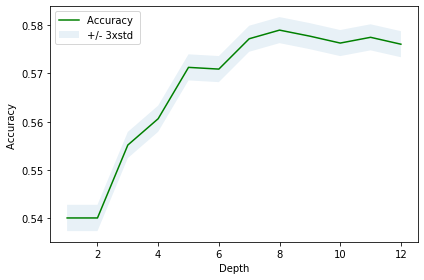

Depth With Max Accuracy : 7 
Max accuracy : 0.5789692930254702




In [26]:

Ks = 13
mean_acc= np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    k_hunter = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_trainset,y_trainset)
    y_hat2=k_hunter.predict(X_testset)
    mean_acc[n-1] = accuracy_score(y_testset, y_hat2)
    std_acc[n-1]=np.std(y_hat2==y_testset)/np.sqrt(y_hat2.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()

Tree_optimizers = []
for i in range(0,len(mean_acc)-1):
    if mean_acc[i] == mean_acc.max():
        Tree_optimizers.append(i)
        print('Depth With Max Accuracy :',i,'\nMax accuracy :',mean_acc.max())

print('\n')
depth_optimized = Tree_optimizers[0]
Tree_optimized = DecisionTreeClassifier(criterion="entropy", max_depth = depth_optimized)
Tree_optimized.fit(X_trainset,y_trainset)
y_hat_optimized = Tree_optimized.predict(X_testset)

In [27]:
# Build the model
SeverityTree = DecisionTreeClassifier(criterion="entropy", max_depth = 11)
SeverityTree # it shows the default parameters

# Fit the model
SeverityTree.fit(X_trainset,y_trainset)

# Make predictions
predTree = SeverityTree.predict(X_testset)
evaluate_ai (y_testset, predTree)

AI's Accuracy:  0.58
AI's Jaccard Similarity Index:  0.29
AI's F1 Score :  0.45
AI's Log Loss:  17.46


### KNN

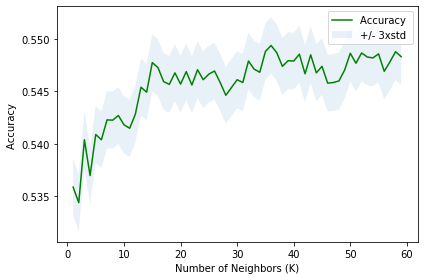

Number of Neighbors With Max Accuracy : 35 
Max accuracy : 0.5493930016662699




In [28]:
Ks = 60
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    k_hunter = KNeighborsClassifier(n_neighbors = n).fit(X_trainset,y_trainset)
    y_hat2=k_hunter.predict(X_testset)
    mean_acc[n-1] = accuracy_score(y_testset, y_hat2)
    std_acc[n-1]=np.std(y_hat2==y_testset)/np.sqrt(y_hat2.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

knn_optimizers = []
for i in range(0,len(mean_acc)-1):
    if mean_acc[i] == mean_acc.max():
        knn_optimizers.append(i)
        print('Number of Neighbors With Max Accuracy :',i,'\nMax accuracy :',mean_acc.max())
knn_optimizers

print('\n')
k_optimized = knn_optimizers[0]
knn_optimized = KNeighborsClassifier(n_neighbors=k_optimized, algorithm='auto')
knn_optimized.fit(X_trainset,y_trainset)
y_hat_optimized = knn_optimized.predict(X_testset)

In [29]:
# Build the model
SeverityNeigh = KNeighborsClassifier(n_neighbors = 21).fit(X_trainset,y_trainset)
SeverityNeigh # it shows the default parameters

# Fit the model
SeverityNeigh.fit(X_trainset,y_trainset)

# Make predictions
predNeigh = SeverityNeigh.predict(X_testset)
evaluate_ai (y_testset, predNeigh)

AI's Accuracy:  0.55
AI's Jaccard Similarity Index:  0.35
AI's F1 Score :  0.52
AI's Log Loss:  17.46


### Support Vector Machine

In [26]:
# going with this one only because don't have resources to figure out optimum
# should look up cleaver ways to figure out optimum ones
# should work on tensor flow and deep learning

clf = svm.SVC(kernel='linear', gamma = 'auto')
clf.fit(X_trainset,y_trainset)
y_hat = clf.predict(X_testset)
evaluate_ai (y_testset, y_hat)

NameError: name 'X_test' is not defined

In [27]:
# results calculated on a faster machine using the code above

AI's Accuracy:  0.56
AI's Jaccard Similarity Index:  0.33
AI's F1 Score :  0.5
AI's Log Loss:  17.46


## Results and Discussion <a name="results"></a>

Various factors were evaluated using linear and non-linear correlations which required them to be encoded in numerical values from the original texts. Descriptive statistical analysis was also carried out. All in all, no significant realtion was identified with any single variable which suggested that multiple variables were at play. 

Since this problem involves assigning labels and not calculating numbers, multiple linear/polynomial regression analysis was not feasible and classification techniques were employed.

Both, Decision Trees and K-Nearest Neighbours were optimzied by running them through k depth/neighbours and the most accurate ones were tested for accuracy via accuracy test, F1 score and Jaccard's Similarity Index. 

Optimized KNN scored better on accuracy test and F1 score whearas decision tree scored better on jaccard similarity index. Owing to better scores and jaccard concept's not truely being a good test since severities ought to be mutually exclusive, KNN is the better option. 

KNN's 56% accuracy on a train-test split ratio of 7:3 confirms the initial assumption that in fact, multiple factors are playing a role to affect the severity of an accident. 

## Conclusion <a name="conclusion"></a>

Purpose of the project was to develop a reliable system to help assess the severity of the distress calls. Via Artificial Intelligence application on refined data, this was achieved though the accuracy of the model should be worked on futher. 

Final decision on the severity, for now, should be made by the human agents while more work is carred out to improve the model. However, given that the location of the accident and some environmental condition can be used to correctly assess severity codes for 60% of the accidents is a feat and with a little more accuracy, this model can actually be deployed. 